# Regressão III - Tarefa

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d

In [4]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [6]:
df['tempo_emprego'].isna().value_counts()

False    624240
True     125760
Name: tempo_emprego, dtype: int64

In [7]:
df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)

In [8]:
df['tempo_emprego'].isna().value_counts()

False    750000
Name: tempo_emprego, dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [9]:
df.index.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [10]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [11]:
# Primeiro iremos reduzir o número de variáveis explicativas utilizando uma regressão LASSO

X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_train)

In [12]:
res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)

resumo = res.summary()
resumo.tables[0]

Dep. Variable:,np.log(renda),R-squared:,0.424
Model:,OLS,Adj. R-squared:,0.424
Method:,Least Squares,F-statistic:,8.823e+04
Date:,"Tue, 11 Oct 2022",Prob (F-statistic):,0.00
Time:,10:09:42,Log-Likelihood:,-8.0490e+05
No. Observations:,600000,AIC:,1.610e+06
Df Residuals:,599995,BIC:,1.610e+06
Df Model:,5,,
Covariance Type:,nonrobust,,


In [13]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|t|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"8,3731","0,0060","1501,8150","0,0000","8,3620","8,3840"
C(sexo)[T.M],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_veiculo)[T.S],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_imovel)[T.S],"0,1786","0,0030","69,4970","0,0000","0,1740","0,1840"
C(tipo_renda)[T.Bolsista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Empresário],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Pensionista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Servidor público],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Fundamental]","0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Médio]","0,0000","0,0000",nan,nan,"0,0000","0,0000"


In [14]:
# Encontramos um modelo com 4 variáveis explicativas

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [15]:
# Categorizando em 20 quantis

df_train['tempo_emprego_cat_init'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)

warnings.filterwarnings('ignore')

C:\Users\rhfariasn\AppData\Local\Temp\ipykernel_30640\2560099666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tempo_emprego_cat_init'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)


In [16]:
df_train.head(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat_init
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]"


In [17]:
quebras

array([ 0.11780822,  0.81643836,  1.45753425,  2.09589041,  2.91232877,
        3.63561644,  4.29863014,  4.93424658,  5.75890411,  6.62191781,
        7.47123288,  7.7461648 ,  8.10684932,  9.08219178, 10.43561644,
       12.46575342, 15.21369863, 20.21643836, 42.90684932])

In [18]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins = quebras, duplicates='drop')

In [19]:
df_train.head(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat_init,tempo_emprego_cat
data_ref,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]","(15.214, 20.216]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]","(9.082, 10.436]"


In [20]:
# Criando tabela de perfil

tab_perfil = pd.DataFrame()

# Coluna para a quantidade de observações de cada categoria

tab_perfil['qtd_obs'] = df_train['tempo_emprego_cat'].value_counts()

# Coluna para a média do log-renda para cada categoria

df_train['log_renda']=np.log(df_train['renda'])

tab_perfil['log_renda_med'] = df_train.groupby('tempo_emprego_cat')['log_renda'].mean()

# Coluna para a média do tempo de emprego para cada categoria

tab_perfil['tempo_emprego_med'] = df_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()

tab_perfil.sort_index(axis = 0, inplace = True)

tab_perfil.reset_index(inplace=True)

tab_perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)

tab_perfil

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.118, 0.816]",30207,8.365576,0.515397
1,"(0.816, 1.458]",30031,8.454323,1.125014
2,"(1.458, 2.096]",29736,8.569544,1.781261
3,"(2.096, 2.912]",30013,8.624148,2.510920
4,"(2.912, 3.636]",30408,8.755365,3.301180
5,"(3.636, 4.299]",29625,8.855078,3.987156
6,"(4.299, 4.934]",30109,8.903273,4.610421
7,"(4.934, 5.759]",29991,9.049495,5.367829
8,"(5.759, 6.622]",30003,9.139216,6.205546
9,"(6.622, 7.471]",29926,9.224298,7.009358


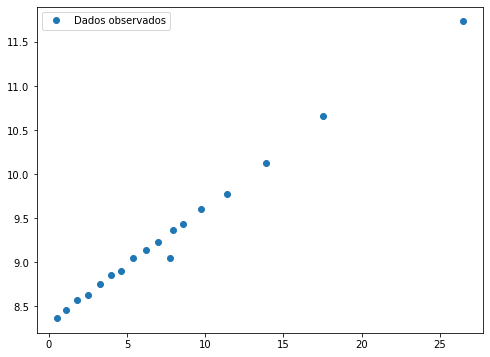

In [21]:
# tab = df_train.merge(y_med, on='tempo_emprego_cat', how='left')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tab_perfil.tempo_emprego_med, tab_perfil.log_renda_med, "o", label="Dados observados", alpha=1)
ax.legend()

**Comentário:** Observando o gráfico, tirando um ponto outlier que é o valor dos clientes que não possuiam valor de tempo_emprego e substituimos pela média, todos os outros valores estão em uma linha o que sugere que uma regressão linear vai ser bem efetiva na modelagem.

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [22]:
# Já que criamos as categorias no item anterior vamos começar com uma Categorização

df_train_b = df_train.merge(tab_perfil, on='tempo_emprego_cat', how='left')
df_train_b.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat_init,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]","(15.214, 20.216]",9.318131,29999.0,10.657687,17.538365
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]","(9.082, 10.436]",7.793508,30005.0,9.599298,9.741024
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]","(8.107, 9.082]",9.528769,29740.0,9.428302,8.572256
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]","(0.816, 1.458]",7.767196,30031.0,8.454323,1.125014
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]","(0.816, 1.458]",6.673020,30031.0,8.454323,1.125014


In [23]:
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_cat 
                    + 1''', df_train_b)

res_2 = smf.ols(X2, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_2.rsquared_adj:.2%}')

R-quadrado ajustado: 41.93%


In [24]:
# Como segunda escolha farei um Lowess

# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_train_b.log_renda, df_train_b.tempo_emprego, frac=2/3)

In [25]:
lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_b['tempo_emprego_lowess'] = f(df_train_b.tempo_emprego)
df_train_b.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat_init,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med,tempo_emprego_lowess
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]","(15.214, 20.216]",9.318131,29999.0,10.657687,17.538365,10.526933
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]","(9.082, 10.436]",7.793508,30005.0,9.599298,9.741024,9.495954
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]","(8.107, 9.082]",9.528769,29740.0,9.428302,8.572256,9.290507
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]","(0.816, 1.458]",7.767196,30031.0,8.454323,1.125014,8.484386
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]","(0.816, 1.458]",6.673020,30031.0,8.454323,1.125014,8.478176


In [26]:
X3 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_train_b)

res_3 = smf.ols(X3, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_3.rsquared_adj:.2%}')

R-quadrado ajustado: 42.60%


**Comentários:** Trabalhar com categorização reduziu levemente o valor do R²-ajustado em comparação com a regressão utilizando os valores padrão de tempo_emprego, já no caso do Lowess tivemos um leve aumento do R²-ajustado.

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [27]:
# Regressão inicial

df_test['log_renda']=np.log(df_test['renda'])

df_test['pred_1'] = res.predict(df_test)

r = df_test[['pred_1', 'log_renda']].corr().iloc[0,1]
r**2

0.5294846659497549

In [28]:
# Categorização

df_test['tempo_emprego_cat'] = pd.cut(df_test.tempo_emprego, bins = quebras, duplicates='drop')

warnings.filterwarnings('ignore')

In [29]:
df_test['tempo_emprego_cat'].isna().value_counts()

False    149991
True          9
Name: tempo_emprego_cat, dtype: int64

In [30]:
df_test.dropna(inplace=True)

In [31]:
df_test['pred_2'] = res_2.predict(df_test)

In [32]:
r = df_test[['pred_2', 'log_renda']].corr().iloc[0,1]
r**2

0.5237613429676313

In [33]:
# Lowess

# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_test.log_renda, df_test.tempo_emprego, frac=2/3)

In [34]:
lowess_x = lowess[:, 0]

lowess_y = lowess[:, 1]

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_test['tempo_emprego_lowess'] = f(df_test.tempo_emprego)
df_test.head(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,pred_1,tempo_emprego_cat,pred_2,tempo_emprego_lowess
data_ref,,,,,,,,,,,,,,,,,,
2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,2137.61,7.667444,9.241157,"(7.471, 7.746]",9.101392,8.041414
2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518,9.642994,"(9.082, 10.436]",9.624259,8.264837


In [35]:
df_test['pred_3'] = res_3.predict(df_test)

In [36]:
r = df_test[['pred_3', 'log_renda']].corr().iloc[0,1]
r**2

0.5326658545441504

**Conclusão:** Na base teste a regressão com Lowess também foi a que apresentou maior R².